In [4]:
import pandas as pd
import os
import dateutil as du
import json


def to_seconds(t):
    return int(du.parser.isoparse(t).timestamp())

pwd = "/home/jfreeman/52/part3"
os.chdir(pwd)

# Set different marker styles for each application
marker_styles = ["o-", "s-", "D-", "*-", "x-", "^-", "v-"]

# Set different colors for each application
colors = {
    "parsec-blackscholes": "#CCACCA",
    "parsec-canneal": "#CCCCAA",
    "parsec-dedup": "#AACCAA",
    "parsec-ferret": "#CC0A00",
    "parsec-freqmine": "#0CCA00",
    "parsec-radix": "#00CCA0",
    "parsec-vips": "#CCA000",
}

policy = {
    "parsec-blackscholes": "[VM3; Core 1]",
    "parsec-canneal": "[VM3; Core 1-2]",
    "parsec-dedup": "[VM3; Core 4-7]",
    "parsec-ferret": "[VM3; Core 0-1]",
    "parsec-freqmine": "[VM2; Core 0]",
    "parsec-radix": "[VM2; Core 0-3]",
    "parsec-vips": "[VM2; Core 0-3]",
    "memcached": "[VM1; Core 0]"
}

# get the start and finish times of each application a of each run i in [1, 2, 3] from 
# the item of data["items"] (a list) of f"../experiments/part3/run{i}/pods.json" such that entry["metadata"]["ownerReferences"][0]["name"] == a.
# we are interested in entry["status"]["containerStatuses"][0]["state"]["terminated"]["startedAt"] and entry["status"]["containerStatuses"][0]["state"]["terminated"]["finishedAt"]
application_names = ["parsec-blackscholes", "parsec-canneal", "parsec-dedup", "parsec-ferret", "parsec-freqmine", "parsec-radix", "parsec-vips"]

start_end_pairs = {}
for i in range(1, 4):
    for app_name in application_names:
        path = f"../experiments/part3/run{i}/pods.json"
        with open(path, "r") as f:
            data = json.load(f)
            # only keep the data entries that have entry["status"]["containerStatuses"][0]["state"]["terminated"]
            data = [entry["status"]["containerStatuses"][0] for entry in data["items"] if "terminated" in entry["status"]["containerStatuses"][0]["state"]]
            
            # entry is the first element in data that has entry["state"]["name"] == appname
            entry = next(entry for entry in data if entry["name"] == app_name)
            start_time = to_seconds(entry["state"]["terminated"]["startedAt"])
            end_time = to_seconds(entry["state"]["terminated"]["finishedAt"])
            start_end_pairs[(i, app_name)] = (start_time, end_time)

print(f"The following is the start and end times for each application of each run: \n{start_end_pairs}")           
            


# all on one thread.
tt_path = f"../experiments/part3/mcperf_msmts.txt"

df = pd.read_csv(tt_path, delim_whitespace=True)
print(f"The following is the data frame for {tt_path}:")
df




The following is the start and end times for each application of each run: 
{(1, 'parsec-blackscholes'): (1715008544, 1715008546), (1, 'parsec-canneal'): (1715008562, 1715008572), (1, 'parsec-dedup'): (1715008545, 1715008568), (1, 'parsec-ferret'): (1715008546, 1715008552), (1, 'parsec-freqmine'): (1715008545, 1715008549), (1, 'parsec-radix'): (1715008545, 1715008578), (1, 'parsec-vips'): (1715008541, 1715008604), (2, 'parsec-blackscholes'): (1715008620, 1715008621), (2, 'parsec-canneal'): (1715008636, 1715008646), (2, 'parsec-dedup'): (1715008619, 1715008642), (2, 'parsec-ferret'): (1715008620, 1715008627), (2, 'parsec-freqmine'): (1715008619, 1715008624), (2, 'parsec-radix'): (1715008619, 1715008653), (2, 'parsec-vips'): (1715008615, 1715008678), (3, 'parsec-blackscholes'): (1715008692, 1715008694), (3, 'parsec-canneal'): (1715008710, 1715008720), (3, 'parsec-dedup'): (1715008694, 1715008717), (3, 'parsec-ferret'): (1715008693, 1715008699), (3, 'parsec-freqmine'): (1715008693, 171500

,#type,avg,std,min,p5,p10,p50,p67,p75,p80,p85,p90,p95,p99,p999,p9999,QPS,target,ts_start,ts_end
0,read,320.9,178.8,160.7,209.6,223.1,298.3,341.0,366.7,385.7,407.4,436.3,480.6,571.8,1775.4,7891.7,30028.8,30000,1715008236464,1715008246624
1,read,306.0,204.5,160.7,207.2,219.6,281.6,318.2,342.1,360.9,383.6,414.3,462.2,544.7,1717.7,9231.4,29981.6,30005,1715008248133,1715008258284
2,read,319.0,185.8,160.7,208.4,221.7,296.3,339.6,365.5,384.5,406.3,436.1,481.4,567.3,1360.5,8315.1,30027.7,30010,1715008259793,1715008269903
3,read,329.4,238.7,148.8,214.5,227.9,305.0,347.2,372.6,391.6,413.9,443.9,491.1,585.4,2485.7,10079.3,30058.6,30015,1715008271412,1715008281527
4,read,323.3,204.2,148.8,208.3,222.3,301.6,344.2,369.2,387.7,408.7,437.7,484.8,575.2,1705.8,9392.4,30006.5,30020,1715008283037,1715008293151
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
68,read,322.2,202.8,160.7,210.9,224.6,300.1,342.4,367.7,386.2,407.1,435.2,479.4,564.0,1466.6,9891.6,30330.5,30340,1715009027026,1715009037135
69,read,318.6,198.1,160.7,207.8,222.1,296.2,337.5,362.2,380.0,401.2,430.2,472.0,562.4,1975.7,8130.2,30372.2,30345,1715009038642,1715009048753
70,read,319.1,196.1,160.7,211.4,223.9,295.4,338.0,363.9,382.8,404.3,433.9,477.6,555.4,1779.8,8340.2,30294.8,30350,1715009050260,1715009060376
71,read,320.5,195.7,148.8,205.6,220.8,300.6,343.6,368.6,386.5,406.1,433.8,474.4,554.4,1242.9,8608.3,30354.8,30355,1715009061886,1715009072006


Earliest start: 1715008541, Latest end: 1715008604 for run 1
Earliest start: 1715008615, Latest end: 1715008678 for run 2
Earliest start: 1715008688, Latest end: 1715008752 for run 3


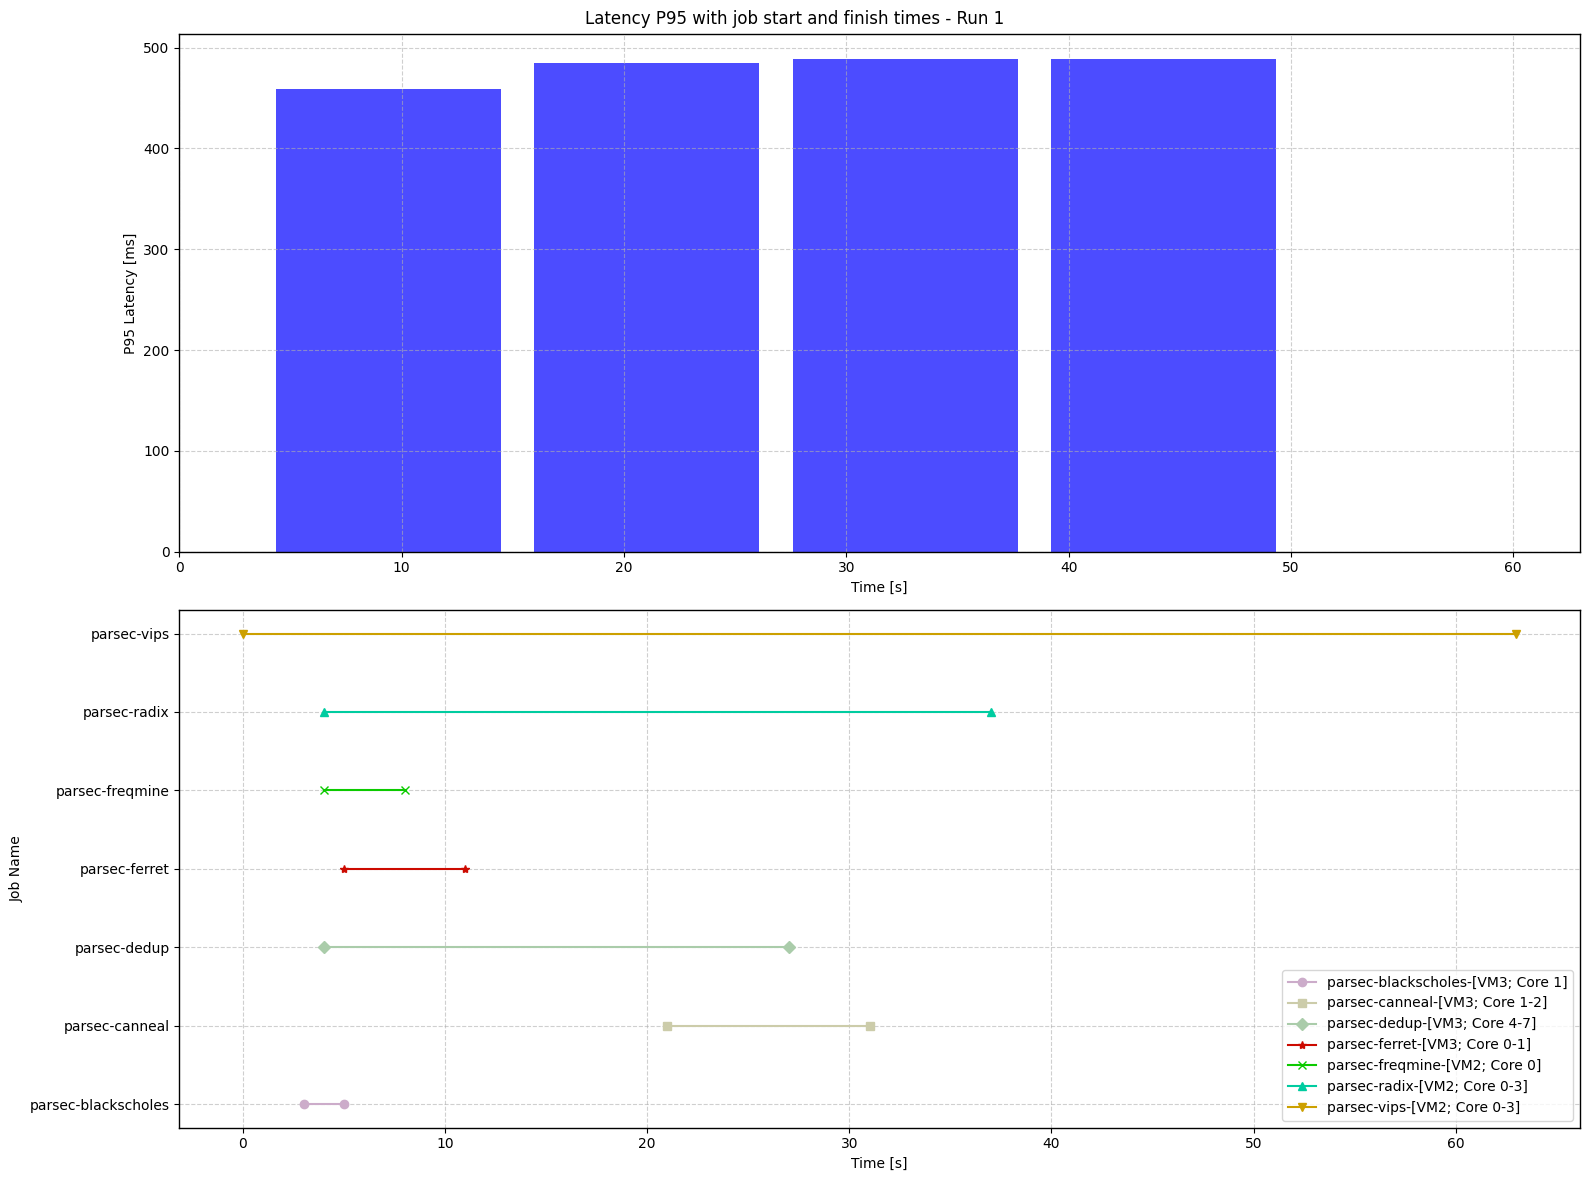

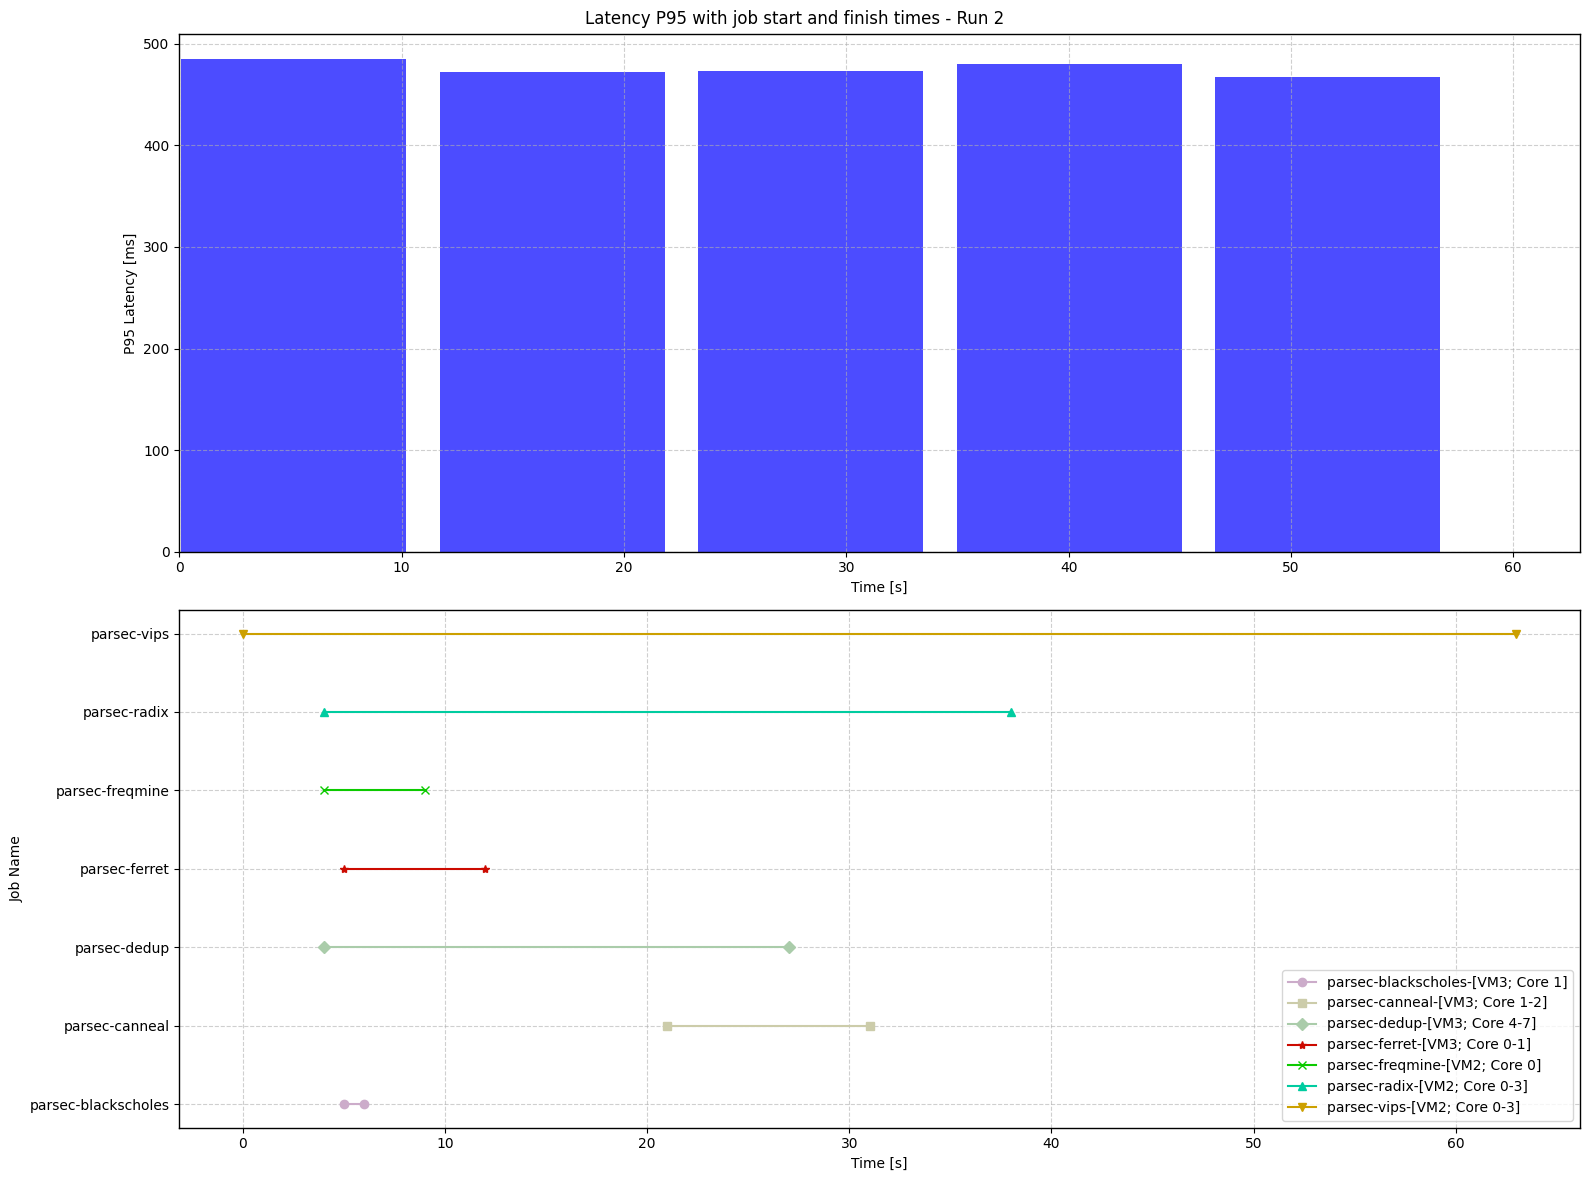

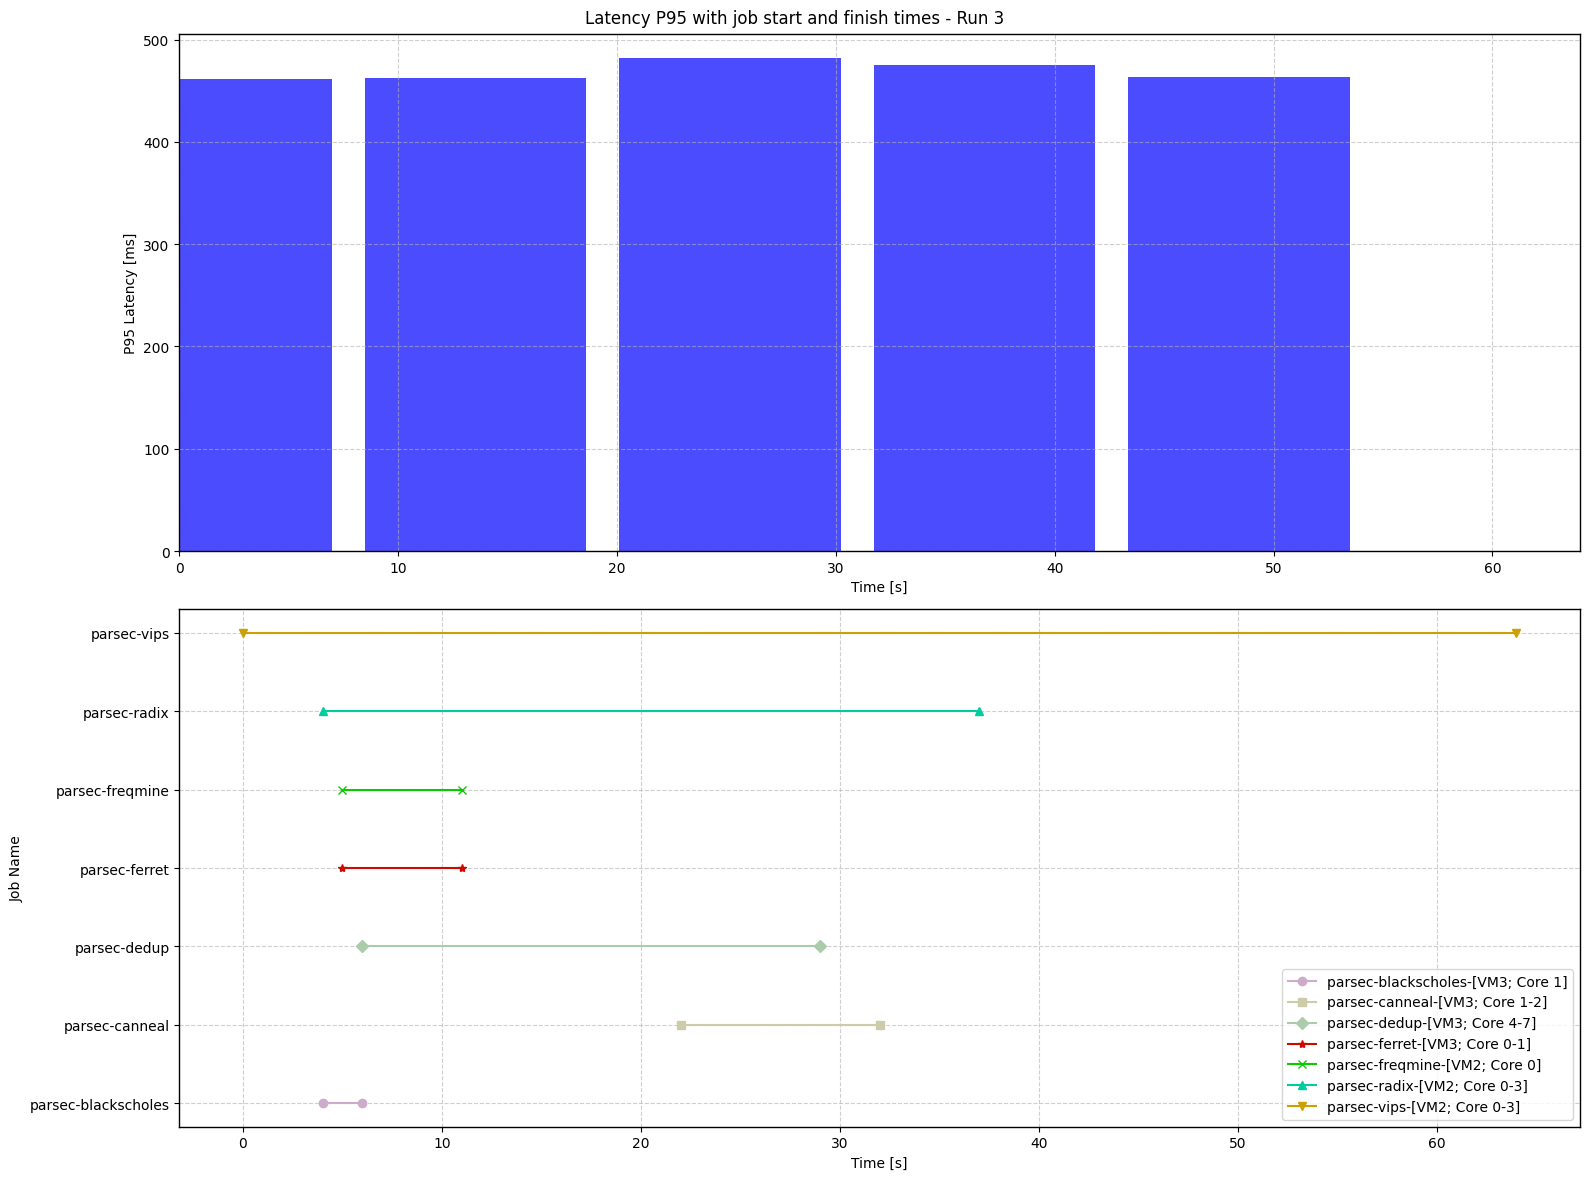

In [13]:
import matplotlib.pyplot as plt
import numpy as np
# make into a dictionary
marker_styles = {app: style for app, style in zip(application_names, marker_styles)}

def create_plots(df, start_end_pairs, marker_styles, colors, policy):
    runs = [1, 2, 3]

    for run in runs:
        start_end_run = {k[1]: v for k, v in start_end_pairs.items() if k[0] == run}

        data_run = df

        earliest_start = np.min([v[0] for v in start_end_run.values()])
        latest_end = np.max([v[1] for v in start_end_run.values()])
        print(f"Earliest start: {earliest_start}, Latest end: {latest_end} for run {run}")

        
        data_run = data_run[(data_run['ts_start'] > earliest_start * 1000) & (data_run['ts_end'] < latest_end * 1000)]

        fig, axs = plt.subplots(2, figsize=(16,12))
        fig.suptitle(f'Latency P95 with job start and finish times - Run {run}')

        for app, times in start_end_run.items():
            start = (times[0] - earliest_start)
            end = (times[1] - earliest_start)

            y = app
            
            axs[1].plot([start, end], [y, y], marker_styles[app], color=colors[app], label=f"{app}-{policy[app]}")

        axs[1].set_xlabel('Time [s]')
        axs[1].set_ylabel('Job Name')

        axs[1].set_yticks(range(len(start_end_run.keys())))
        axs[1].set_yticklabels(start_end_run.keys())

        axs[1].grid(True, linestyle='--', alpha=0.6)
        axs[1].legend(loc='best')

        latencies = data_run['p95']
        start_times = (data_run['ts_start'] - earliest_start*1000) / 1000
        widths = (data_run['ts_end'] - data_run['ts_start']) / 1000

        axs[0].bar(start_times, latencies, width=widths, color='blue', alpha=0.7)
        axs[0].set_xlabel('Time [s]')
        axs[0].set_ylabel('P95 Latency [ms]')
        
        axs[0].grid(True, linestyle='--', alpha=0.6)
        axs[0].set_xlim([0, (latest_end - earliest_start)])

        for ax in axs:
            for spine in ax.spines.values():
                spine.set_color('black')
                spine.set_linewidth(1)

        plt.tight_layout()
        # plt.savefig(f'part_3_figure_{run}.png', dpi=300, facecolor=fig.get_facecolor(), edgecolor='none')

create_plots(df, start_end_pairs, marker_styles, colors, policy)